# IST 718 Laboratory Exercise - 3

Created by: Victoria Haley

Date: 2/12/2024

In [1]:
# Loading necessary libraries
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings("ignore")
from keras.datasets import fashion_mnist
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report
import time

2024-02-13 16:10:44.243998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Research Question: Can we use algorithms and compute to identify clothing items?
Specifically, can we determine which algorithm and compute methodology provides us the most
efficient approach for classifying simple fashion images??

## Step 1: Obtain data and understand data structures and data elements

In [2]:
# Load the data and split the data into training and testing
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()
 
# Print the dimensions of the dataset
print('Train: X = ', trainX.shape)
print('Test: X = ', testX.shape)

Train: X =  (60000, 28, 28)
Test: X =  (10000, 28, 28)


The Training set has 60,000 images that are 28 x 28 pixels, and the Test set has 10,000 images that are also 28 x 28 pixels. With the shape being 28 x 28, the image has a dimension of 784. This is a relatively low number, meaning that no dimension reduction will be needed.

In [3]:
# Label data structure and elements
print('Number of training lables:', len(trainX))
print()
print('Overiew of the training labels:')
print(trainy)
print()
print('Number of test lables:', len(testy))
print()
print('Overiew of the test labels:')
print(testy)

Number of training lables: 60000

Overiew of the training labels:
[9 0 0 ... 3 0 5]

Number of test lables: 10000

Overiew of the test labels:
[9 2 1 ... 8 1 5]


There are 60,000 training and 10,000 test labels with an integer that ranges from 0-9.

In [4]:
# Creating dictionary of class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Step 2: Scrub data using scripting methods, to include debugging, for data manipulation

In [5]:
# Adding an extra dimension to allow for color
trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)
 
print(trainX.shape)

(60000, 28, 28, 1)


Now the images are 28 x 28 x 1.

Not much data scrubbing or manipulation is needed for this data set due to the nature of data and purpose of this report.

## Step 3: Explore data using essential qualitative analysis techniques including descriptive statistics

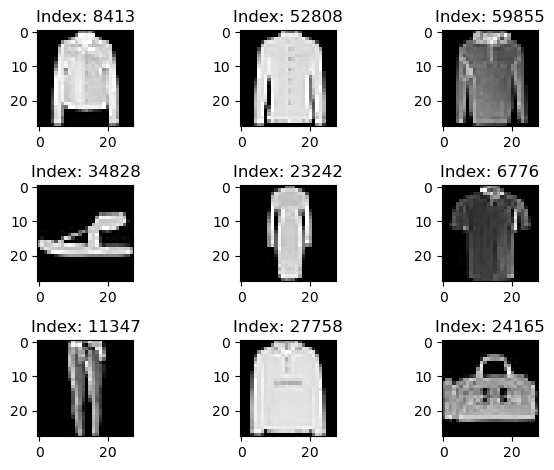

In [6]:
# Sample of images in the training set

# Generate 9 random indices
random_indices = np.random.randint(0, len(trainX), 9)

# Sample of random images in the training set
for i, index in enumerate(random_indices, 1):
    # Create a 3x3 grid and place the image in ith position of the grid
    plt.subplot(3, 3, i)
    # Insert ith image with the color map 'gray'
    plt.imshow(trainX[index], cmap=plt.get_cmap('gray'))
    plt.title(f"Index: {index}")

# Display the entire plot
plt.tight_layout()
plt.show()

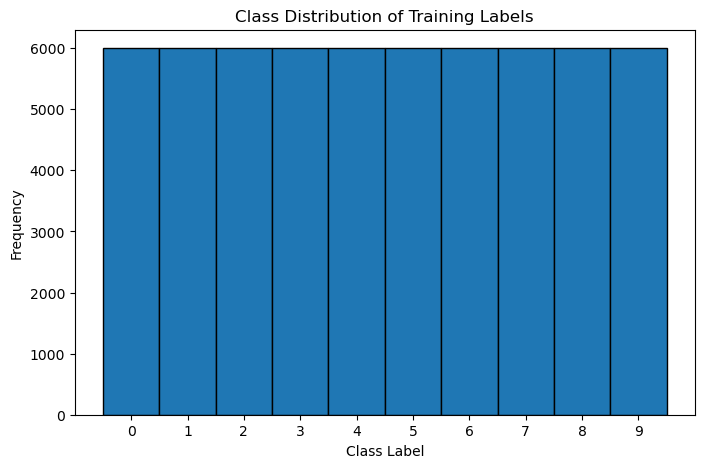

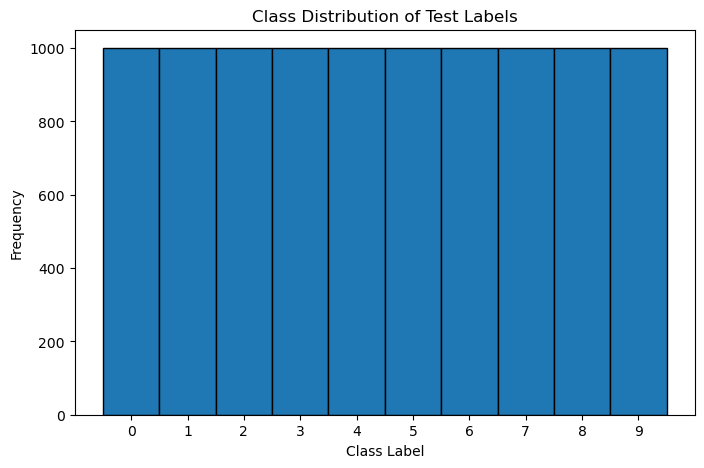

In [7]:
# Class Distribution: train
plt.figure(figsize=(8, 5))
plt.hist(trainy, bins=range(11), edgecolor='black', align='left')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.xticks(range(10))
plt.title('Class Distribution of Training Labels')
plt.show()

# Class Distribution: test
plt.figure(figsize=(8, 5))
plt.hist(testy, bins=range(11), edgecolor='black', align='left')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.xticks(range(10))
plt.title('Class Distribution of Test Labels')
plt.show()

Both of the training and testing labels have an even distribution of classes, which is good for judging how well the accuracy of the predictions are.

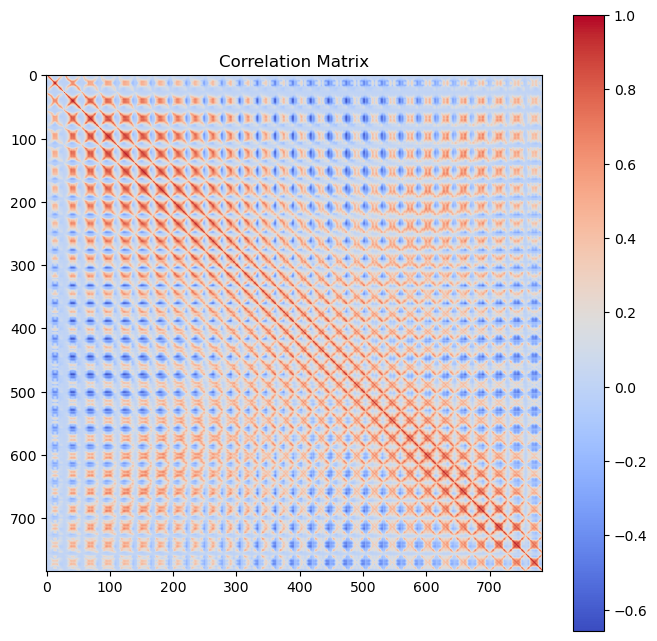

In [8]:
# Flatten the images
pixel_values = trainX.reshape(trainX.shape[0], -1)

# Correlation Analysis
correlation_matrix = np.corrcoef(pixel_values.T)  # Transpose pixel_values for correct computation
plt.figure(figsize=(8, 8))
plt.imshow(correlation_matrix, cmap='coolwarm')
plt.colorbar()
plt.title('Correlation Matrix')
plt.show()

No clear, definitive standouts for positive or negative relationships. However, we can see that there appears to be a decent amount of relatively strong relationships between pixel values in the training set.

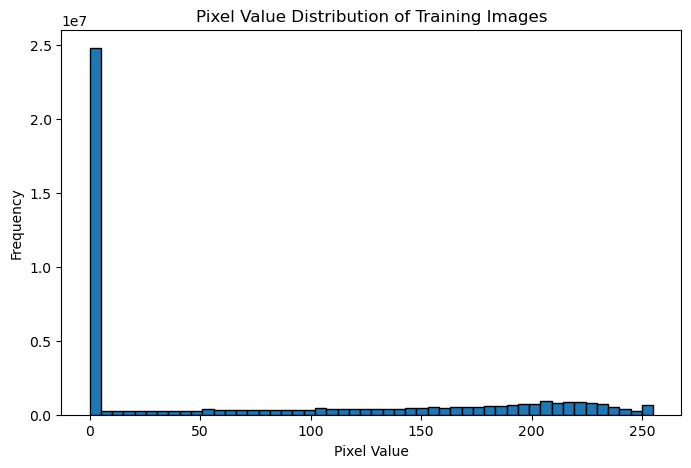

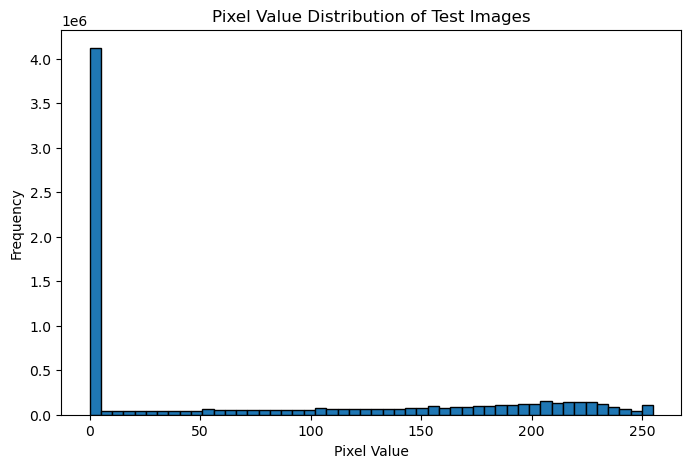

In [9]:
# Feature Analysis: train
pixel_values = trainX.reshape(-1)  # Flatten the images
plt.figure(figsize=(8, 5))
plt.hist(pixel_values, bins=50, edgecolor='black')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Pixel Value Distribution of Training Images')
plt.show()

# Feature Analysis: test
pixel_values = testX.reshape(-1)  # Flatten the images
plt.figure(figsize=(8, 5))
plt.hist(pixel_values, bins=50, edgecolor='black')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Pixel Value Distribution of Test Images')
plt.show()

The plots above show the frequencies of the values of each pixel. We can see that the values range from 0 to 255, with the most being in the 0-5 bin. Besides that, it appears as though most values are within 150 to 255.

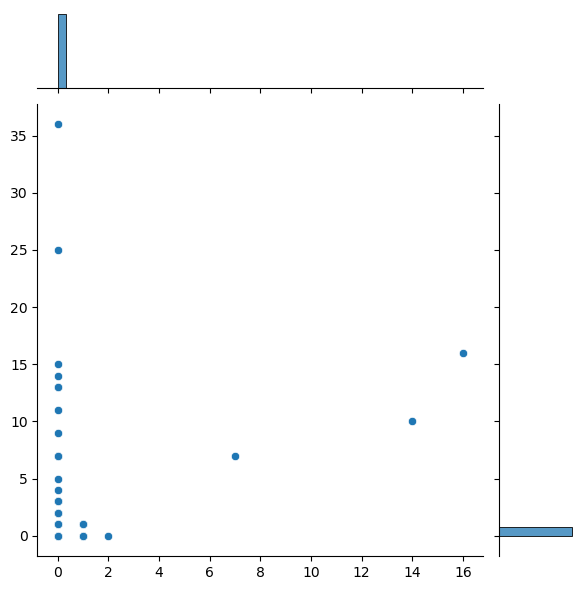

In [10]:
# Joint plot

# Flatten the images
flattened_images = trainX.reshape(trainX.shape[0], -1)

# Take the first two features for visualization
x_data = flattened_images[:, 0]
y_data = flattened_images[:, 1]

# Create a joint plot
sns.jointplot(x=x_data, y=y_data, kind='scatter', marginal_kws=dict(bins=50, fill=True))

# Show the plot
plt.show()

Another glimpse at the pixel data of the example flattened image above. 

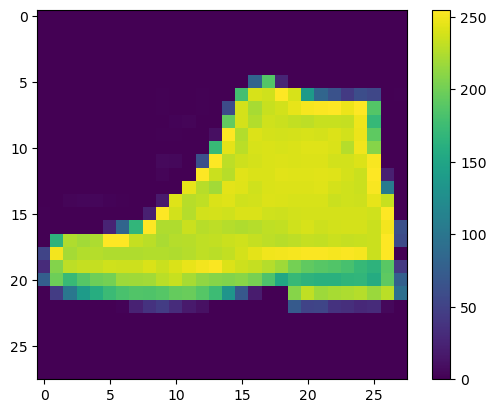

In [11]:
# Inspecting random image
plt.figure()
plt.imshow(trainX[42])
plt.colorbar()
plt.grid(False)
plt.show()

Here we can see the pixel values of image #43 from the training set. The heatmap also aligns with the plots above that show that most values are 0 (pixels where there is no shoe) to 255.

These values will need to be scaled down to 0 or 1 for classification purposes.

In [12]:
# Scaling the values
trainX = trainX / 255.0

testX = testX / 255.0

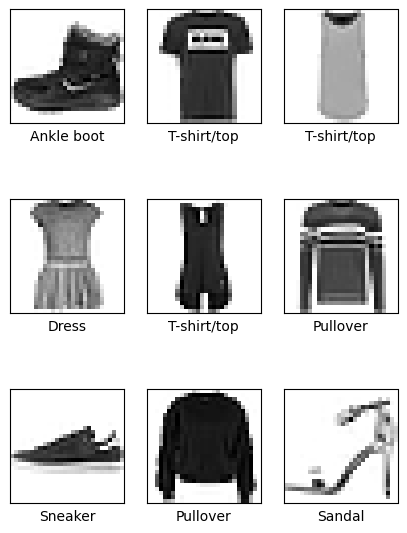

In [13]:
# Verify the changes

# Set the figure size
plt.figure(figsize=(5, 7))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainX[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[trainy[i]])
plt.show()

## Step 4: Model relationships between data using the appropriate analytical methodologies matched to the information and the needs of clients and users

Implementing at least two approaches for classifying the digits:
A Keras model, a Random Forest, and an XGBoost model.

### Keras Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
1500/1500 [==============================] - 11s 5ms/step - loss: 0.5164 - accuracy: 0.8205 - val_loss: 0.4024 - val_accuracy: 0.8593
Epoch 2/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3865 - accuracy: 0.8606 - val_loss: 0.3847 - val_accuracy

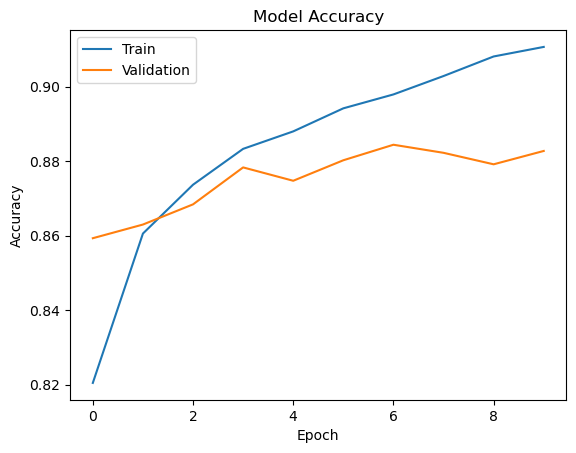

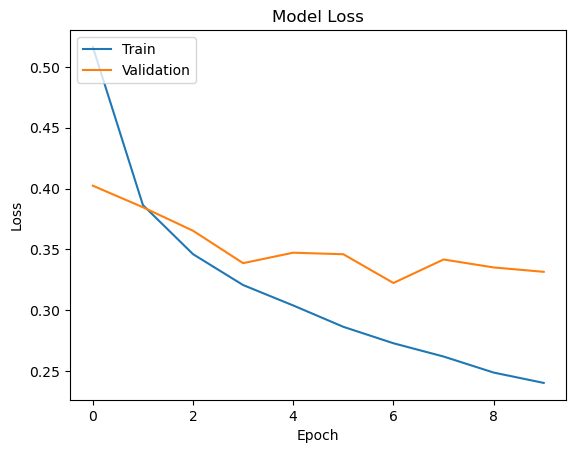

In [14]:
# The data is already pre-processed, so we'll jump right into the model building

# To track compute performance
start_time = time.time()

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)), # Unstack the pixels from 28 x 28 2D to 784 1D
    tf.keras.layers.Dense(128, activation='relu'), # First layers with 128 neurons
    tf.keras.layers.Dense(10) # Second layer with 10 neurons (one for each class)
])


# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Print model summary
model.summary()

# Train the model with early stopping
history = model.fit(trainX, trainy, epochs=20, validation_split=0.2, callbacks=[early_stopping])

end_time = time.time()
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))

# Accuracy vs Epoch plot
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss vs Epoch plot
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

After 10 epochs, the model achieved:
- Training accuracy: 91.07%
- Validation accuracy: 88.27%
- Training loss: 0.2404
- Validation loss: 0.3316

These results indicate that the model is performing quite well, with slightly higher accuracy on the training data compared to the validation data, suggesting some degree of overfitting. Although the difference between training and validation accuracy is not too significant, there is still some room for improvement.

In [15]:
# Evaluate accuracy on test data
test_loss, test_acc = model.evaluate(testX,  testy, verbose=2)

print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

313/313 - 2s - loss: 0.3542 - accuracy: 0.8760 - 2s/epoch - 6ms/step

Test loss: 0.3541710078716278

Test accuracy: 0.8759999871253967


Compared to the results from training, (Training Accuracy: 91.07%, Validation Accuracy: 88.27%, Training Loss: 0.2404, Validation Loss: 0.3316), the model achieved a relatively low loss and a high accuracy, however it also validates the signs of overfitting seen above.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
1500/1500 [==============================] - 9s 5ms/step - loss: 0.6816 - accuracy: 0.8143 - val_loss: 0.5629 - val_accuracy: 0.8433
Epoch 2/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.5443 - accuracy: 0.8468 - val_loss: 0.5566 - val_accurac

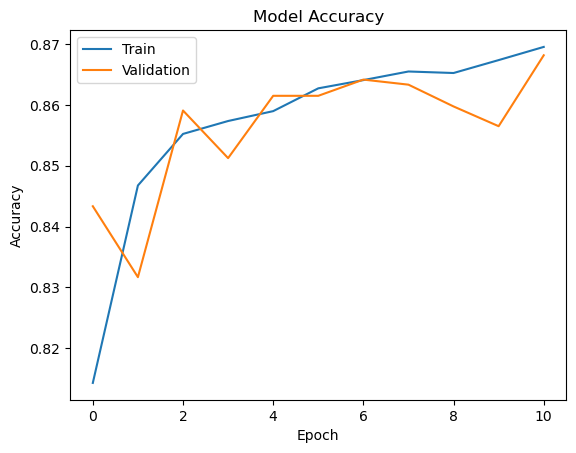

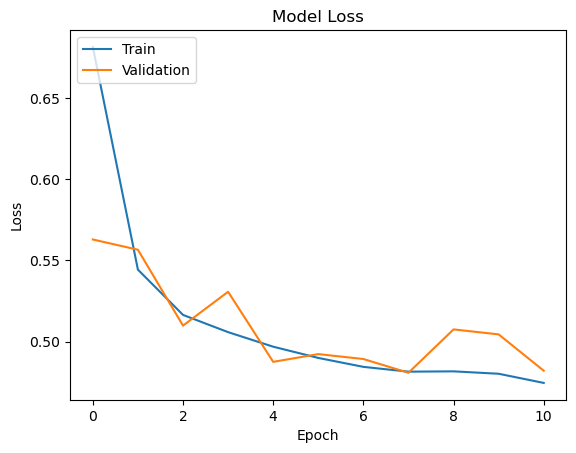

In [16]:
# To track compute performance
start_time = time.time()

# Define the model
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)), # Unstack the pixels from 28 x 28 2D to 784 1D
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), # Add L2 regularization
    tf.keras.layers.Dense(10, kernel_regularizer=tf.keras.regularizers.l2(0.001)) # Add L2 regularization
])

# Compile the model
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Print model summary
model2.summary()

# Train the model with early stopping
history2 = model2.fit(trainX, trainy, epochs=20, validation_split=0.2, callbacks=[early_stopping])

end_time = time.time()
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))

# Accuracy vs Epoch plot
plt.plot(history2.history['accuracy'])  
plt.plot(history2.history['val_accuracy'])  
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Loss vs Epoch plot
plt.plot(history2.history['loss'])  
plt.plot(history2.history['val_loss'])  
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
# Evaluate accuracy on test data
test_loss2, test_acc2 = model2.evaluate(testX,  testy, verbose=2)

print('\nTest loss:', test_loss2)
print('\nTest accuracy:', test_acc2)

313/313 - 2s - loss: 0.5024 - accuracy: 0.8607 - 2s/epoch - 7ms/step

Test loss: 0.502371609210968

Test accuracy: 0.8607000112533569


The new model achieved the following results:
- Training accuracy: 86.95%
- Validation accuracy: 86.82%
- Test accuracy: 86.07%
- Training loss: 0.4745
- Validation loss: 0.4820
- Test loss: 0.5024

Compared to the first model, this model has slightly lower accuracy and higher loss on both the training and validation datasets. This could indicate that the L2 regularization introduced in the dense layers may be affecting the model's performance negatively in this case. However, because of the smaller differences between the training, validation, and test metrics, the second model will be the one used going forward as it doesn't overfit like the first model.

In [18]:
# Making predictions

# To track compute performance
start_time = time.time()

# Add softmax layer to produce logits for the probability of the predictions 
probability_model = tf.keras.Sequential([model2, 
                                         tf.keras.layers.Softmax()])

# Saving predictions
predictions = probability_model.predict(testX)

# Define function to plot predictions
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

end_time = time.time()
inference_time = end_time - start_time
print("Inference Time: {:.2f} seconds".format(inference_time))

313/313 [==============================] - 2s 4ms/step
Inference Time: 3.88 seconds


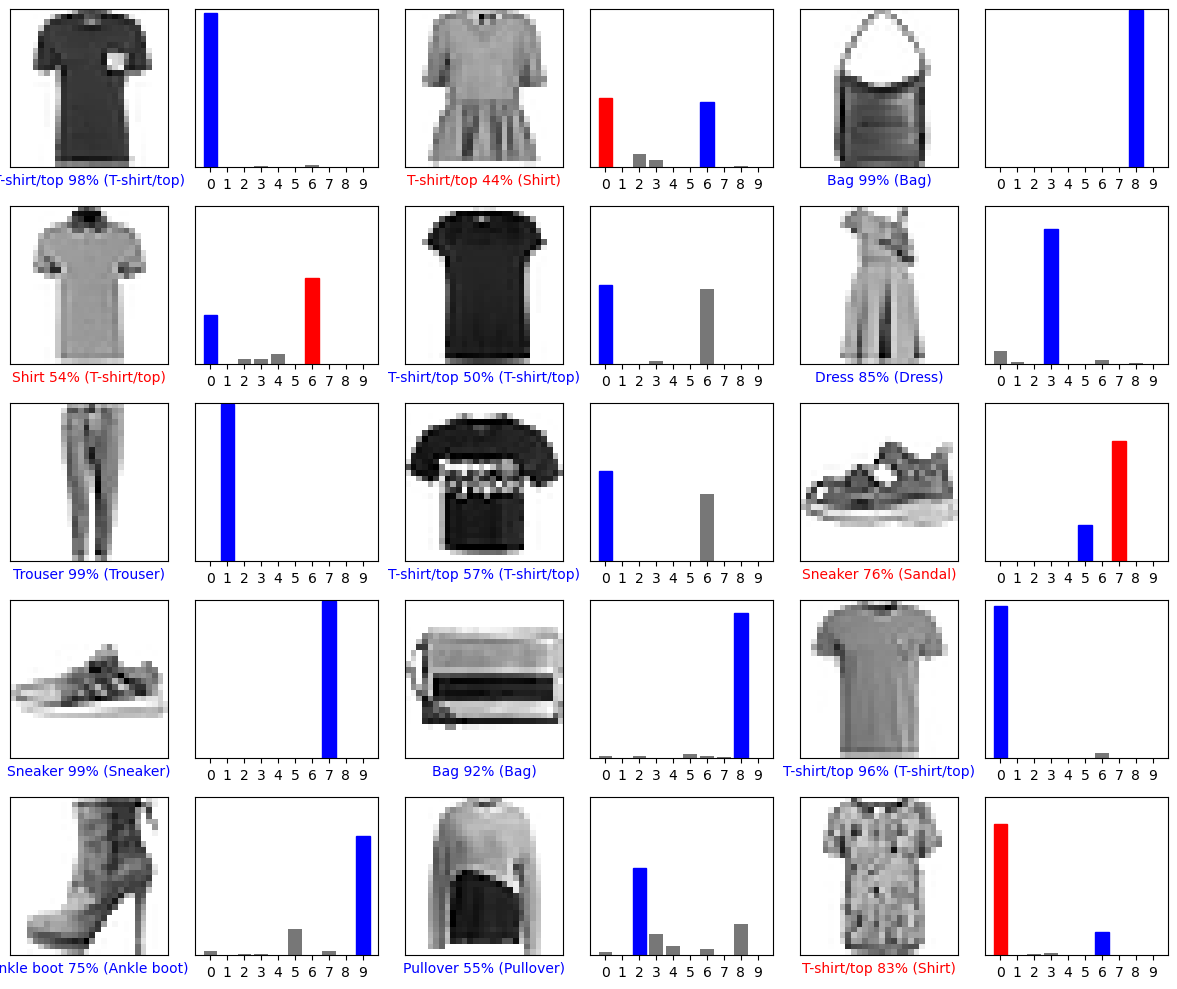

In [19]:
# Plot random test images, their predicted labels, and the true labels.
    # Correct predictions in blue and incorrect predictions in red.

# Select random indices from the test set
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
random_indices = np.random.choice(len(testX), size=num_images, replace=False)

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i, idx in enumerate(random_indices):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(idx, predictions[idx], testy, testX)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(idx, predictions[idx], testy)
plt.tight_layout()
plt.show()

The plot above shows that the model correctly predicted 11/15 (73.3%) of the images. However, the incorrect predictions could be due to the naming conventions of the clothing. For example, the 2nd image in the 1st row was a shirt but the model indicated that there was a 44% chance that it was a t-shirt/top. I'm unsure what the specific difference between a shirt and t-shirt/top is, but I would argue that the model was correct here.

1/1 [==============================] - 0s 111ms/step
Inference Time: 0.96 seconds


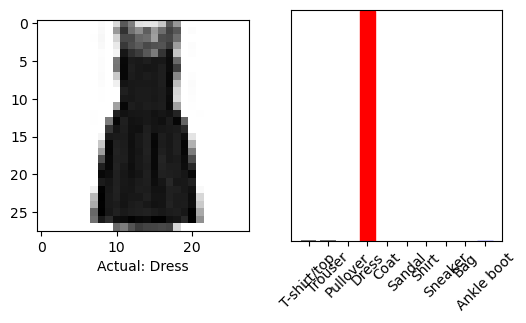

In [21]:
# Prediction on a single random image

# To track compute performance
start_time = time.time()

# Select a single image and its corresponding label
image_index = 330  
selected_image = testX[image_index]
selected_label = testy[image_index]

# Expand dimensions to match model input shape (add batch dimension)
selected_image = np.expand_dims(selected_image, axis=0)

# Make prediction on the selected image
predictions_single = probability_model.predict(selected_image)

end_time = time.time()
inference_time = end_time - start_time
print("Inference Time: {:.2f} seconds".format(inference_time))

# Plot the actual image
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(selected_image[0], cmap=plt.cm.binary)
plt.xlabel("Actual: " + class_names[selected_label])

# Plot the prediction value array
plt.subplot(1,2,2)
plot_value_array(0, predictions_single[0], testy)
_ = plt.xticks(range(10), class_names, rotation=45)

plt.show()

On a single image, the model incorrectly predicted that image 330 was a pullover when it was actually a dress.

## Summary of Keras Model
Overall, the Keras model achieved impressive performance metrics:
- Training accuracy: 86.95%
- Validation accuracy: 86.82%
- Test accuracy: 86.07%
- Training loss: 0.4745
- Validation loss: 0.4820
- Test loss: 0.5024

The model performed well on both the training and validation datasets, with not much of a decrease in accuracy on the test dataset, indicating that it generalized well to unseen data.

However, when analyzing individual predictions, it's important to note that the model made some incorrect predictions. For example, it incorrectly classified an image of a shirt as a t-shirt/top, which is likely due to the semantics of the class names. Additionally, there was an instance where the model predicted an image of a sandal as a sneaker, which is understandable as it was a sort of sporty sandal.

These incorrect predictions suggest that while the model achieved good overall accuracy, there are still limitations in its ability to distinguish between similar clothing items, particularly when they share similar visual features.

Overall, the Keras model demonstrates strong performance on the Fashion MNIST dataset, achieving high accuracy and low loss metrics. However, it's important to consider the context of individual predictions and potential challenges in correctly classifying similar clothing items. Further improvements or fine-tuning of the model may be beneficial to address these specific challenges and enhance its performance in distinguishing between visually similar classes, especially when the definitions of shirt v. t-shirt/top and other types of clothing sometimes overlap.

## Random Forest and XGBoost Models

These models will be run together due to their similarities.

Random Forest Accuracy: 0.8764
Training Time: 100.18 seconds

XGBoost Accuracy: 0.8985
Training Time: 335.51 seconds



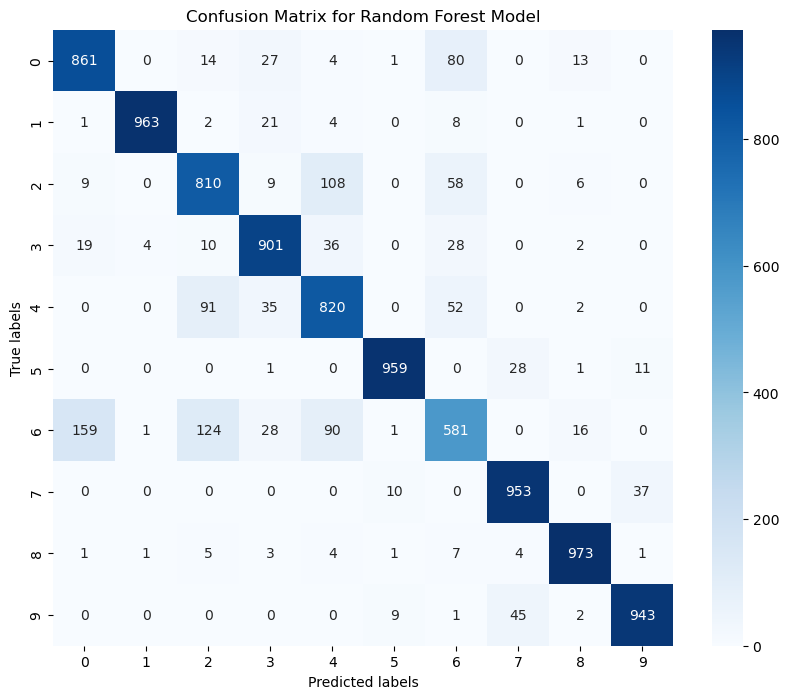

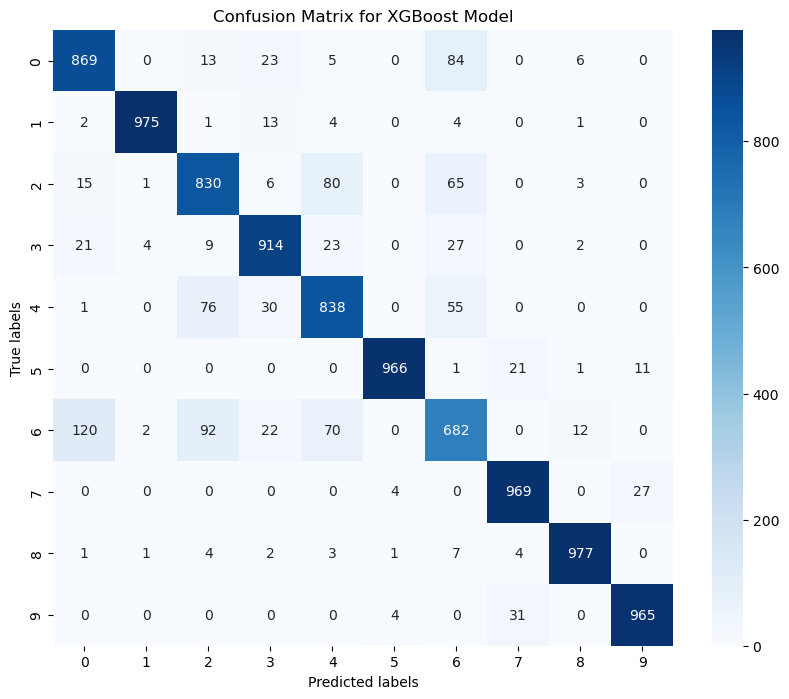

In [22]:
# To track compute performance
start_time = time.time()


# Flatten the images
trainX_flat = trainX.reshape((60000, 28*28))
testX_flat = testX.reshape((10000, 28*28))

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(trainX_flat, trainy)
rf_pred = rf_model.predict(testX_flat)
rf_acc = accuracy_score(testy, rf_pred)
print(f'Random Forest Accuracy: {rf_acc}')

end_time = time.time()
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))
print()

# XGBoost model

# To track compute performance
start_time = time.time()

xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(trainX_flat, trainy)
xgb_pred = xgb_model.predict(testX_flat)
xgb_acc = accuracy_score(testy, xgb_pred)
print(f'XGBoost Accuracy: {xgb_acc}')

end_time = time.time()
training_time = end_time - start_time
print("Training Time: {:.2f} seconds".format(training_time))
print()

# Confusion matrix for Random Forest
rf_cm = confusion_matrix(testy, rf_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()


# Confusion matrix for XGBoost
conf_mat = confusion_matrix(testy, xgb_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for XGBoost Model')
plt.show()

Here we can see that the random forest model was 87.64% accurate at making predictions, as well as how many predictions of each class were corredt (dark blue diagonal line) and how many times the model predicted inaccurately. For example, the model predicted a 6 as a 0 159 times.

The XGBoost model was slightly more accurate at 89.85%. Interestinly, it also struggled the most with label #6, incorrectly predicting as 0 120 times.

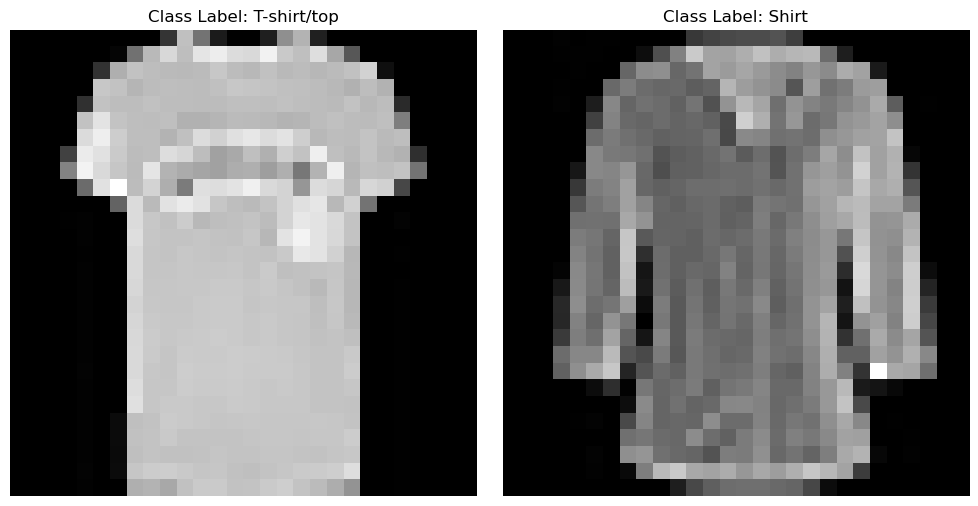

In [25]:
# Find the index of the first occurrence of label 0 in testy
index_0 = np.argmax(testy == 0)

# Get the corresponding image from testX
image_0 = testX[index_0]

# Get the class label corresponding to label 0
class_label_0 = class_names[0]  

# Find the index of the first occurrence of label 6 in testy
index_6 = np.argmax(testy == 6)

# Get the corresponding image from testX
image_6 = testX[index_6]

# Get the class label corresponding to label 6
class_label_6 = class_names[6]  

# Plot both images
plt.figure(figsize=(10, 5))

# Plot image with label 0
plt.subplot(1, 2, 1)
plt.imshow(image_0, cmap='gray')
plt.title(f"Class Label: {class_label_0}")
plt.axis('off')

# Plot image with label 6
plt.subplot(1, 2, 2)
plt.imshow(image_6, cmap='gray')
plt.title(f"Class Label: {class_label_6}")
plt.axis('off')

plt.tight_layout()
plt.show()

Here we can see an example of what a 0 (left) and a 6 (right) look like.

In [23]:
#Evaluating the models

# For Random Forest

# To track compute performance
start_time = time.time()

rf_classification_report = classification_report(testy, rf_pred)
print("Random Forest Classification Report:")
print(rf_classification_report)

end_time = time.time()
inference_time = end_time - start_time
print("Inference Time: {:.2f} seconds".format(inference_time))

print()

# For XGBoost

# To track compute performance
start_time = time.time()

xgb_classification_report = classification_report(testy, xgb_pred)
print("XGBoost Classification Report:")
print(xgb_classification_report)

end_time = time.time()
inference_time = end_time - start_time
print("Inference Time: {:.2f} seconds".format(inference_time))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.77      0.81      0.79      1000
           3       0.88      0.90      0.89      1000
           4       0.77      0.82      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.71      0.58      0.64      1000
           7       0.93      0.95      0.94      1000
           8       0.96      0.97      0.97      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000

Inference Time: 0.06 seconds

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1000
           1       0.99      0.97 

### Random Forest Model:
Overall accuracy: 88%

The model achieved varying precision, recall, and F1-score for different classes.

Precision represents the proportion of true positive predictions among all positive predictions for each class. For example, for class 1, the precision is 0.99, indicating that 99% of the predicted instances labeled as class 1 are correct.

Recall represents the proportion of true positive predictions among all actual positive instances for each class. For example, for class 6, the recall is 0.68, indicating that 68% of the actual instances labeled as class 6 were correctly predicted.

F1-score provides a balanced measure between precision and recall for each class.

The macro avg and weighted avg metrics provide the average precision, recall, and F1-score across all classes. 

In this case, the macro avg and weighted avg values are similar due to the balanced distribution of classes in the dataset.

### XGBoost Model:
Overall accuracy: 90%

Similar to the Random Forest model, the XGBoost model achieved varying precision, recall, and F1-score for different classes.

The model generally performed better across all metrics compared to the Random Forest model.

The precision, recall, and F1-score for each class indicate the model's ability to correctly classify instances for that particular class.

The macro avg and weighted avg metrics provide the average precision, recall, and F1-score across all classes. 

The XGBoost model also performed better in terms of macro avg and weighted avg metrics compared to the Random Forest model.

### Interpretations:
Both models achieved good overall accuracy, with the XGBoost model slightly outperforming the Random Forest model.

The XGBoost model generally exhibited higher precision, recall, and F1-score values across most classes compared to the Random Forest model, indicating better performance in classifying instances.

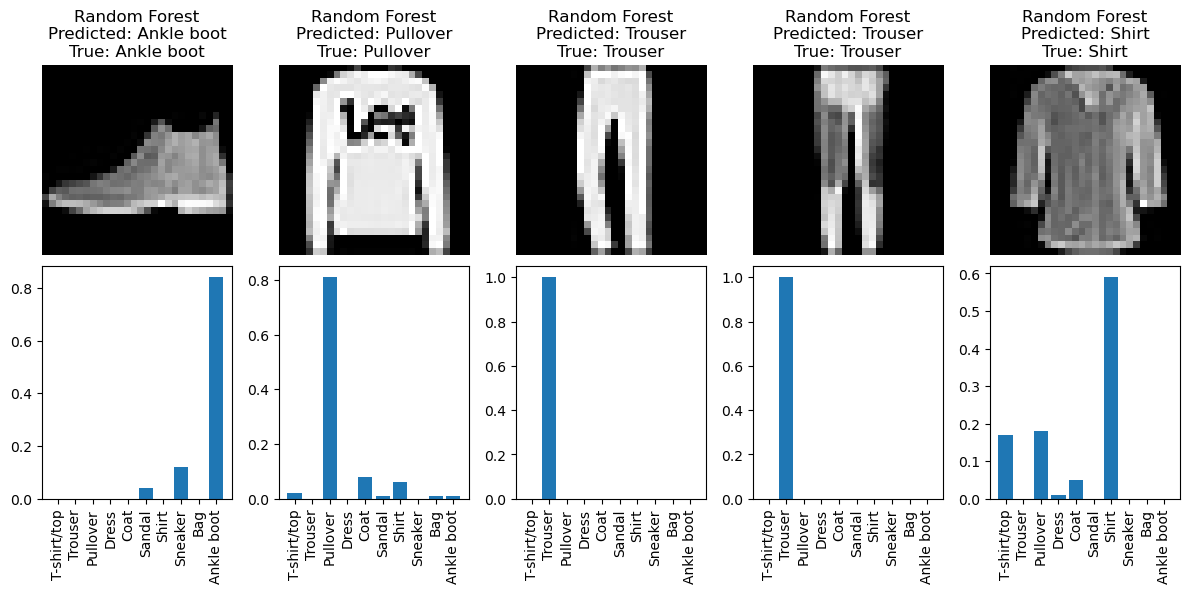

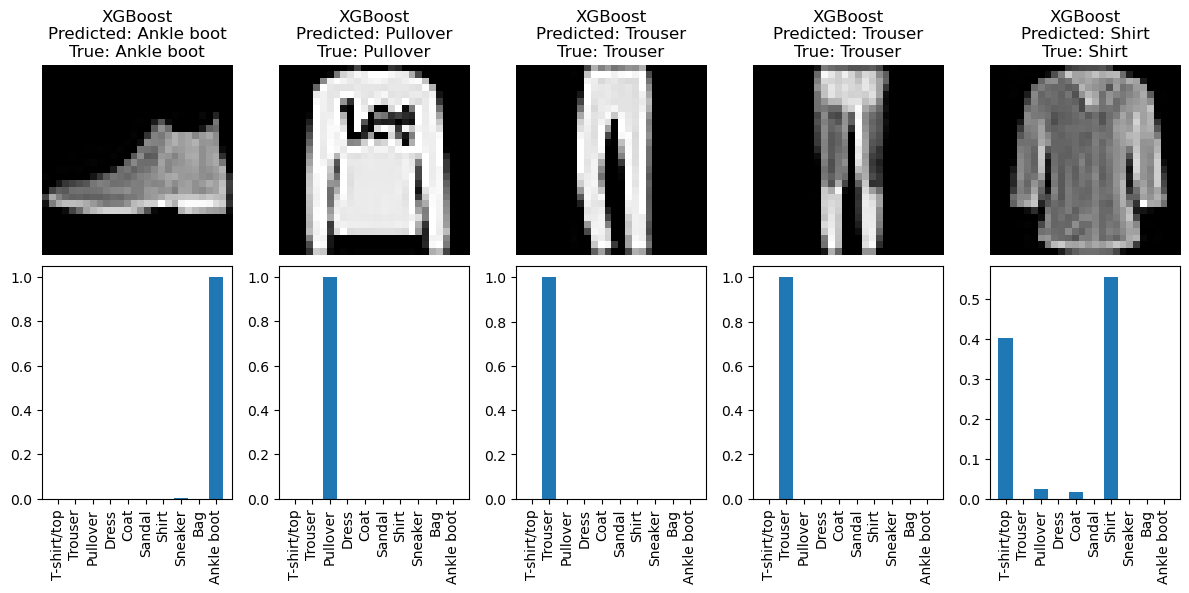

In [24]:
# Visualizing the performance

# Plot the images along with their predicted labels and true labels for Random Forest
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(testX[i].reshape(28, 28), cmap='gray')
    plt.title(f'Random Forest\nPredicted: {class_names[rf_pred[i]]}\nTrue: {class_names[testy[i]]}')
    plt.axis('off')
    plt.subplot(2, 5, i + 6)
    plt.bar(range(10), rf_model.predict_proba(testX[i].reshape(1, -1))[0])
    plt.xticks(range(10), class_names, rotation=90)

plt.tight_layout()
plt.show()

# Plot the images along with their predicted labels and true labels for XGBoost
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(testX[i].reshape(28, 28), cmap='gray')
    plt.title(f'XGBoost\nPredicted: {class_names[xgb_pred[i]]}\nTrue: {class_names[testy[i]]}')
    plt.axis('off')
    plt.subplot(2, 5, i + 6)
    plt.bar(range(10), xgb_model.predict_proba(testX[i].reshape(1, -1))[0])
    plt.xticks(range(10), class_names, rotation=90)

plt.tight_layout()
plt.show()

The plots above show us that both the Random Forest and XGBoost models were 5/5 on those predictions. However, looking at the plots of the value arrays show that the XGBoost model was more confident with its predictions.

# Step 5: INterpret the data, model, analysis, and findings.

## What is the accuracy of each method?

Keras Model Test accuracy: 86.07%

Random Forest: 88%

XGBoost: 90%

## What are the tradeoffs of each approach?

### Keras Model:

Advantages:
- Can learn complex patterns and relationships in the data.
- Can handle large amounts of data with high dimensionality.
- Can automatically extract features from the data.

Tradeoffs:
- Requires large amounts of data for training, which can be computationally expensive.
- Can be prone to overfitting, especially with complex architectures.
- Hyperparameter tuning and model selection can be time-consuming.

### Random Forest:

Advantages:
- Robust to overfitting, especially when using many trees.
- Can handle both numerical and categorical data.
- Provides feature importances, making it easy to interpret the model.

Tradeoffs:
- May not perform well on very high-dimensional data.
- Limited ability to capture complex patterns compared to the keras models.
- Training time can be longer compared to simpler models.

### XGBoost:

Advantages:
- Can handle complex nonlinear relationships in the data.
- Often provides better performance compared to traditional machine learning algorithms.
- Fast training speed compared to deep learning models.

Tradeoffs:
- Requires careful tuning of hyperparameters.
- May not perform well on very high-dimensional data or data with many categories.
- Can be sensitive to outliers and noisy data.

## What is the compute performance of each approach?

Total training and inference time for Keras model: 157.53 seconds

Total training and inference time for Random Forest: 100.24 seconds

Total training and inference time for XGBoost: 331.55 seconds

# Summary

This report aimed to analyze and compare the performance of machine learning models, including a Keras deep learning model, Random Forest, and XGBoost, using the Fashion MNIST dataset. The analysis followed a structured approach, starting with data preprocessing and model implementation, followed by evaluation and visualization of model performance.

The Keras model demonstrated good overall accuracy of 86.07%, but with relatively longer training time compared to the other models. Both Random Forest and XGBoost models achieved higher accuracies of 88% and 90% respectively, with shorter training times. While Random Forest provided interpretability through feature importances, XGBoost emerged as a favorable option, balancing accuracy,and interpretability.

Visualization techniques were employed to better understand model predictions and identify areas of improvement. Additionally, classification reports were generated to assess precision, recall, and F1-scores for each class, providing insights into model performance across different categories.

Overall, the project showcased the effectiveness of different machine learning approaches in classifying fashion items, providing valuable insights into the strengths and trade-offs of each method. The analysis contributes to the understanding of model performance and serves as a foundation for further optimization and refinement in future projects.